# Cross Stitch Patterns from Images

This code will create a counted cross-stitch pattern from an image by pixellating it, determining color maps and replacing each pixel by an x in the designated color.  One can choose how many different colors to allow for a given image so that it is possible to minimize the complexity.  A color count of stitches will also be reported so the relative amounts of different color threads can be determined.

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Load image file

In [3]:
import scipy.ndimage as ndi
from scipy.misc import imresize
import requests
from StringIO import StringIO


In [4]:
response = requests.get("http://upload.wikimedia.org/wikipedia/commons/1/1c/CMS_Higgs-event.jpg")
pic = ndi.imread(StringIO(response.content))
print type(pic)

<type 'numpy.ndarray'>


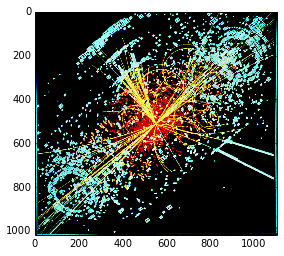

In [5]:
plt.imshow(pic);

In [6]:
print pic.shape
print pic[100,100]

(1018, 1104, 3)
[0 0 0]


Cross-stitching is done with a material called "Aida Cloth".  The size of the weave is measured by how many stitches can be made in one inch. This is called the fabric's count. The most common counts in Aida Cloth are 11, 14, 18 and 28. The higher the number, the smaller the stitches will be, because there are more stitches in each inch. 

For a 20 inch by 20 inch picture, using 14 count Aida Cloth, you have 280 stitches by 280 stitches.  

If you want to reproduce a picture pixel for pixel, divide the number of pixels in a given dimension by the fabric count for the Aida Cloth you intend to use.  That will show you how large the resulting pattern will be.  e.g. for the Higgs event shown above, with 28 count Aida cloth, the image will be 39 x 36 inches - 3 feet by 3 feet.  

# Image adjustment

In [7]:
#resize image
def resize(image,scale=25):
    """scale = % to resize.  This seems to also convert the 0-1 colors to integer RGB"""
    return imresize(image,scale,mode="RGB")

In [8]:
import scipy as sp
from scipy.cluster.vq import kmeans,vq
from sklearn.utils import shuffle

In [9]:
#Kmeans algorithm to reduce number of colors
def reduce_colors(image, k):
    '''Apply kmeans algorithm.
   Input:  image, number of clusters to use
   Output: colors, counts per color, new image'''
    if k > 24:
        k = 24
        print "Setting colors to maximum allowed of 24"
    rows, cols, rgb = image.shape
    # reshape the image in a single row array of RGB pixels
    image_row = np.reshape(image,(rows * cols, 3))
    #HERE ADD CODE TO GET A GOOD GUESS OF COLORS AND PASS THAT AS
    #SECOND ARGUMENT TO kmeans
    #image_array_sample = shuffle(image_row, random_state=0)[:1000]
    #kguess = kmeans(image_array_sample, k)
    #colors,_ = kmeans(image_row, kguess)
    # perform the clustering
    colors,_ = kmeans(image_row, k)
    # vector quantization, assign to each pixel the index of the nearest centroid (i=1..k)
    qnt,_ = vq(image_row,colors)
    # reshape the qnt vector to the original image shape
    image_centers_id = np.reshape(qnt,(rows, cols))
    # assign the color value to each pixel
    newimage = colors[image_centers_id]
    #count number of pixels of each cluster color
    counts,bins = sp.histogram(qnt, len(colors))
    return colors, counts, newimage

#JLK: Look into providing an array of RGB values corresponding to 
#available floss and using those to determine the clustering

# Color/Floss counting

In [10]:
#count colors
def color_count(image):
    """Considering a (w,h,3) image of (dtype=ubyte),
    compute the number of unique colors\n"""
    F = image[...,0]*256*256 + image[...,1]*256 + image[...,2]
    unique, counts = np.unique(F, return_counts=True)
    return unique, counts

In [26]:
#Found an online RGB<-->DMC floss color conversion table to reference.
def load_floss_colors(example=True):
    values = np.loadtxt('DMCtoRGB_JLK.txt', delimiter=' , ',dtype=int, usecols=[0,2,3,4])
    labels = np.loadtxt('DMCtoRGB_JLK.txt', delimiter=' , ',dtype=str, usecols=[1,5])
    if example:
        print "Example: ",values[27],labels[27]
    return values,labels

In [12]:
#Use distance in RGB space to determine closest color match
def match_color(rgb,method="Euclidean"):
    """for a given r,g,b tuple, determine the closest DMC thread color"""
    values,labels = load_floss_colors(False)
    #Use color metric from http://www.compuphase.com/cmetric.htm
    rmean = (rgb[0]-values[:,1]) / 2.
    r = rgb[0]-values[:,1]
    g = rgb[1]-values[:,2]
    b = rgb[2]-values[:,3]
    match = np.sqrt(((2+rmean/256.)*r*r) + 4*g*g + (((2 + (255-rmean)/256.)*b*b)))
    #return values[match.argmin()],labels[match.argmin()]
             
#    #Compute distance to nearest color in RGB space
    rdiff2 = (rgb[0]-values[:,1])**2
    gdiff2 = (rgb[1]-values[:,2])**2
    bdiff2 = (rgb[2]-values[:,3])**2
    cdiff = np.sqrt(rdiff2+gdiff2+bdiff2)
#    #print "Input rgb: ",rgb,"\tClosest match:",values[cdiff.argmin()],labels[cdiff.argmin()]

    if method == "Euclidean":
        return values[cdiff.argmin()],labels[cdiff.argmin()]
    else:
        return values[match.argmin()],labels[match.argmin()]

In [66]:
#Print and return the matched floss counts
def floss_color_counts(colors,counts):
    '''print the matched floss colors and counts'''
    mycounts = counts.copy() #copy so we don't mess up the original arrays
    inds = mycounts.argsort()
    sortedcolors = colors[inds].copy() #copy so we don't mess up the original arrays
    mycounts.sort()
    
    #floss length per stitch for 14-count aida cloth
    boxsize = 25.4/14 #mm
    #diagonal of box
    boxdiag = np.sqrt(2*boxsize**2)
    threadperstitch = 2*boxdiag + 2*boxsize
    threadperstitch *= 1.2 #increase by 20% to account for extras and gaps between stitches
    
    threadpercolor = mycounts*threadperstitch/1000. #number of meters of floss needed in each color
    #floss comes in skeins of 8.7 yards of 6-stranded thread.  Typical 14-count patterns take 2 strands
    flosslength = 3*8.7*0.9144 #convert yards of 6-stranded thread to meters of 2-stranded thread
    skeinspercolor = threadpercolor/flosslength # need to round up
    #print "Box size (mm): %.2f, Box diag (mm): %.2f, threadperstitch (mm): %.2f, flosslength (m): %.2f"%(boxsize,boxdiag,threadperstitch,flosslength)
    #print "THREADPERCOLOR (m):",threadpercolor[-1:0:-1]
    #print "SKEINSPERCOLOR:",skeinspercolor[-1:0:-1]
    
    #Create a list of skein color count, code, and name
    summary = []
    print "Counts\tRGBColor\tFloss#\tFlossRGB\t#Skeins\tFlossName"
    print "====================================================================================="    
    for i in range(len(counts)-1,-1,-1):
        matches = match_color(sortedcolors[i])
        print mycounts[i],"\t",sortedcolors[i],"\t",matches[0][0],"\t",matches[0][1:],"\t %.2f"%skeinspercolor[i],"\t",matches[1]
        summary.append((float("%.2f"%skeinspercolor[i]),matches[0][0],matches[1][0],(sortedcolors[i]),(matches[0][1:])))

    return summary

In [14]:
#replace color at x,y coordinates (in pixel space) with floss color RGB to check the image fidelity
def replace_color(image,color,match):
    print color,"\t--->\t",match
    indices = np.where(np.all(image == color, axis=-1))
    #print image[indices[0],indices[1]]
    image[indices[0],indices[1]] = match
    #print image[indices[0],indices[1]]
    
#JLK: TO_DO: Make small boxes showing the before and after colors next to the RGB

# Utilities

In [15]:
#Print some useful pattern info
def aida_size(pic,aida=14):
    """Given an Aida cloth count and an image of a given number of pixels,
    report the size of the resulting pattern in inches"""
    x,y,col = pic.shape
    print "Pixel dimensions: (%d x %d)"%(x,y)
    print "Aida Cloth count: %d"%aida
    print "Pattern dimensions: (%.2f in x %.2f in)"%(x/float(aida),y/float(aida))
    print "Pattern colors: %d"%(color_count(pic)[0]).size
    return x/float(aida), y/float(aida)

In [16]:
#Plot the image before and after manipulation
def plot_before_after(before,after,text="Transformed"):
    cb = color_count(before)[0].size
    ca = color_count(after)[0].size
    # Two subplots, the axes array is 1-d
    f, axarr = plt.subplots(1,2,figsize=(12, 6))
    axarr[0].imshow(before)
    axarr[0].set_title('Original image (%d colors)'%cb)
    axarr[1].set_title('%s image (%d colors)'%(text,ca))
    axarr[1].imshow(after);

#Applied to Data 

## Resize the image

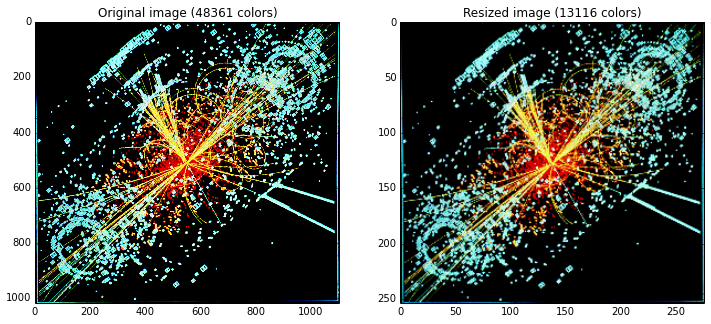

In [17]:
before = pic
smaller = resize(pic)
plot_before_after(before,smaller,"Resized")

---

#Apply color algorithm

In [44]:
#Takes a while.  We might try seeding the kmeans with decent guesses, 
#similar to what is done in scikit-learn
colors, counts, after = reduce_colors(smaller, 32)

Setting colors to maximum allowed of 24


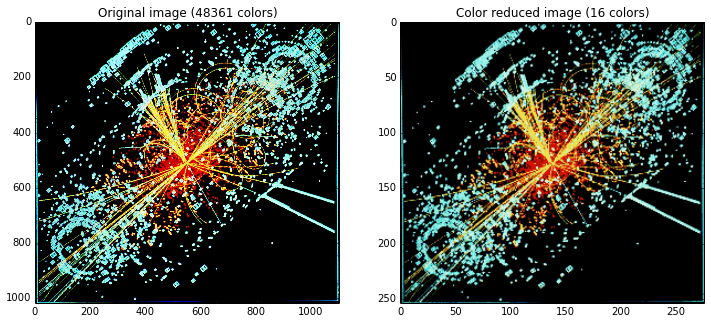

In [45]:
plot_before_after(before,after,"Color reduced")

# Show the results of the color match

In [67]:
#Counts of each color in RGB
summary = floss_color_counts(colors,counts)
#print summary

Counts	RGBColor	Floss#	FlossRGB	#Skeins	FlossName
46285 	[0 0 0] 	310 	[0 0 0] 	 20.39 	['Black' '000000']
3609 	[152 239 231] 	964 	[169 226 216] 	 1.59 	['Sea Green Light ' 'A9E2D8']
3159 	[208 244 228] 	775 	[217 235 241] 	 1.39 	['Baby Blue Very Light ' 'D9EBF1']
2315 	[234 223  79] 	726 	[253 215  85] 	 1.02 	['Topaz Light ' 'FDD755']
1854 	[ 86 226 222] 	959 	[ 89 199 180] 	 0.82 	['Sea Green Med ' '59C7B4']
1430 	[58  9  5] 	938 	[54 31 14] 	 0.63 	['Coffee Brown Ult Dk ' '361F0E']
1342 	[214  16   5] 	817 	[187   5  31] 	 0.59 	['Coral Red Very Dark' 'BB051F']
1331 	[ 5 13 37] 	3371 	[30 17  8] 	 0.59 	['Black Brown ' '1E1108']
1232 	[ 50 172 170] 	958 	[ 62 182 161] 	 0.54 	['Sea Green Dark ' '3EB6A1']
1206 	[ 32 115 119] 	3847 	[ 52 125 117] 	 0.53 	['Teal Green Dark' '347D75']
1154 	[218 128  28] 	922 	[226 115  35] 	 0.51 	['Copper Light ' 'E27323']
949 	[137  16   5] 	815 	[135   7  31] 	 0.42 	['Garnet Medium' '87071F']
939 	[147 205 165] 	3817 	[153 195 170] 	 0.41 	['Ce

In [20]:
sizex,sizey = aida_size(after,aida=14)

Pixel dimensions: (254 x 276)
Aida Cloth count: 14
Pattern dimensions: (18.14 in x 19.71 in)
Pattern colors: 16


#Replace colors with matched floss colors 

Replacing image colors with matched floss color:
[0 0 0] 	--->	[0 0 0]
[152 239 231] 	--->	[169 226 216]
[208 244 228] 	--->	[217 235 241]
[234 223  79] 	--->	[253 215  85]
[ 86 226 222] 	--->	[ 89 199 180]
[58  9  5] 	--->	[54 31 14]
[214  16   5] 	--->	[187   5  31]
[ 5 13 37] 	--->	[30 17  8]
[ 50 172 170] 	--->	[ 62 182 161]
[ 32 115 119] 	--->	[ 52 125 117]
[218 128  28] 	--->	[226 115  35]
[137  16   5] 	--->	[135   7  31]
[147 205 165] 	--->	[153 195 170]
[23 63 25] 	--->	[23 73 35]
[13 55 85] 	--->	[14 54 92]
[99 99 29] 	--->	[ 85 120  34]
[148 167  61] 	--->	[148 171  79]


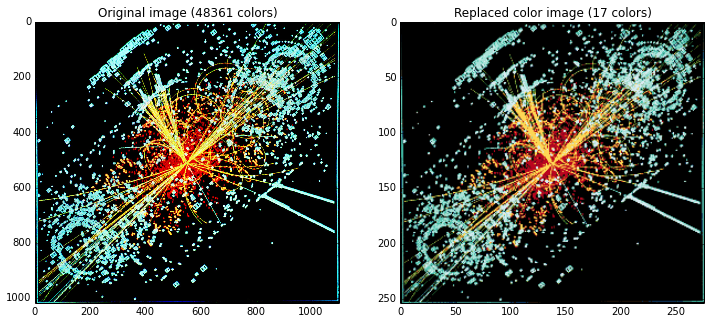

In [68]:
#Use a copy so we don't mess with the original reduced image
test = after.copy()
print "Replacing image colors with matched floss color:"
for (skeins, floss, name, oldcolor, matchedcolor) in summary:
    #print skeins,"\t",name,"\t",floss
    #print matchedcolor
    replace_color(test,oldcolor,matchedcolor)
    
plot_before_after(before,test,"Replaced color")

##Hmmmm....

Much better color match with new DMC RGB mapping.

In [69]:
def view_colors(summary):
    vals,labs = load_floss_colors(example=False)
    fig = plt.figure(1,figsize=(15,15))
    plt.axes()

    count = 0
    #Plot original and matched colors
    for (skeins, floss, name, oldcolor, matchedcolor) in summary:
        circle = plt.Circle((count, 26), radius=0.5, fc=(oldcolor[0]/255.,oldcolor[1]/255.,oldcolor[2]/255.));
        plt.gca().add_patch(circle)
        plt.plot([-2,27],[25.5,25.5],"k")
        circle2 = plt.Circle((count, 25), radius=0.5, fc=(matchedcolor[0]/255.,matchedcolor[1]/255.,matchedcolor[2]/255.));
        plt.gca().add_patch(circle2)
        plt.text(count,24,floss,va='center', ha='center',fontsize=10)
        count += 1

    plt.text(17,25.75,"Original Colors",fontsize=15)
    plt.text(17,24.75,"Matched Floss",fontsize=15)
    plt.text(-6,22,"DMC Flosses:",fontsize=15)
    
    #Plot available floss colors
    for i in range(len(vals)):
        row=i/20
        col=i%20
        circle = plt.Circle((col, row), radius=0.5, fc=(vals[i,1]/255.,vals[i,2]/255.,vals[i,3]/255.));
        plt.gca().add_patch(circle)
        plt.text(col,row,vals[i,0],va='center', ha='center',fontsize=10)
        plt.axis('scaled')
    plt.xlim(-2,22)
    plt.ylim(-2,27)
    plt.show()

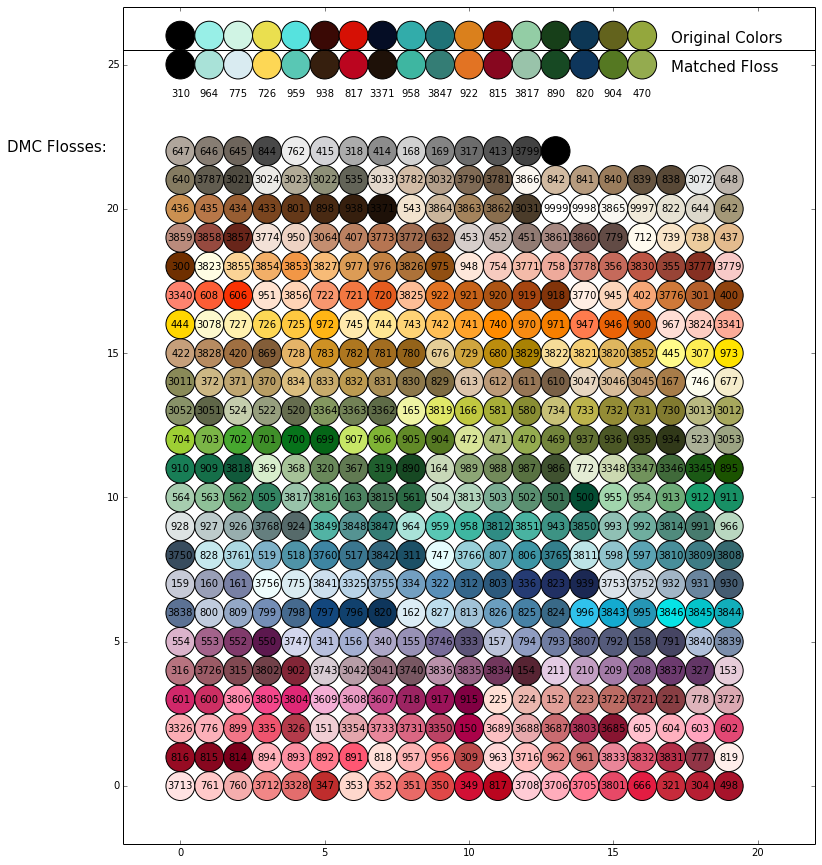

In [70]:
view_colors(summary)

---

# Create pattern

Now that the size and colors have been reduced, represent each color by a character and plot those characters on a 2-D grid representing the image.

In [22]:
#retrieve x,y coordinates (in pixel space) of all pixels of a given color
def locate_color(image,color):
    indices = np.where(np.all(image == color, axis=-1))
    #print zip(indices[0], indices[1])
    return indices[1], indices[0] #row,col vs. x,y

In [23]:
#plot symbols corresponding to different values
symbol = [r'\star',r'\vartriangle',r'\circ',r'\diamond',r'\pi',r'\phi',
          r'\alpha',r'\ominus',r'\oplus',r'\otimes',r'\odot',r'\times',
          r'\pitchfork',r'\bowtie',r'\plus',r'\minus',r'\sim',r'\vartriangleright',
          r'\oslash',r'\ast',r'\nu',r'\aleph',r'\asymp',r'\blacktriangle']

print symbol
print len(summary)
#symbol = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'o', '*', 'c', 'x', 'n', 'z']

import matplotlib.colors as mplcolors
mpc = []
for name, hex in matplotlib.colors.cnames.iteritems():
    mpc.append(name)

['\\star', '\\vartriangle', '\\circ', '\\diamond', '\\pi', '\\phi', '\\alpha', '\\ominus', '\\oplus', '\\otimes', '\\odot', '\\times', '\\pitchfork', '\\bowtie', '\\plus', '\\minus', '\\sim', '\\vartriangleright', '\\oslash', '\\ast', '\\nu', '\\aleph', '\\asymp', '\\blacktriangle']
16


In [24]:
#Figure out how to squeeze it into 1x2 or 2x1 pieces of 8.5x11 or 11x17 paper

#each paper has 16 inches of width to work with and 10 inches of height
#need to squish the smallest dimension onto 16", then let largest dimension
#span two pieces of paper tall.

w,h = 16.,10.
width = min(sizex,sizey)
height = max(sizex,sizey)
red = (width/w) # % reduction
print height/red
print after.shape[0]/2,after.shape[0]+10.
#plt.figure(figsize=(figsize,figsize))
#ax = plt.axes([0.025, 0.025, 0.95, 0.95])

17.3858267717
127 264.0


17.3858267717
pxymin,pxymax:	127 254
ymin,ymax:	(127.0, 264.0)
pxxmin,pxxmax:	0 276
xmin,xmax:	(-10.0, 286.0)


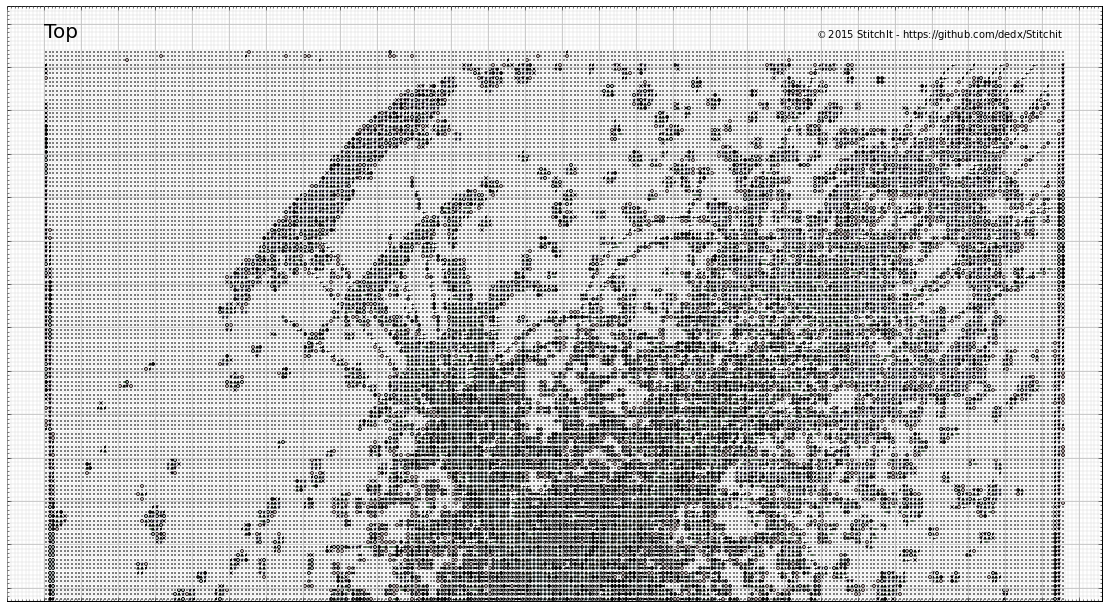

In [34]:
#From https://scipy-lectures.github.io/intro/matplotlib/matplotlib.html#axes
w,h = 16.,10.
width = min(sizex,sizey)
red = (width/w) # % reduction
height = max(sizex,sizey)/red
print height

plt.figure(1,figsize=(w,height/2))
ax = plt.axes([0.025, 0.025, 0.95, 0.95])

#Need these sizes in pixel space
ax.set_xlim(-10,(after.shape[1])+10) #Row,Col vs. x,y
ax.set_ylim((after.shape[0]/2),after.shape[0]+10) #with padding around image
ax.xaxis.set_major_locator(plt.MultipleLocator(10.))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1.))
ax.yaxis.set_major_locator(plt.MultipleLocator(10.))
ax.yaxis.set_minor_locator(plt.MultipleLocator(1.))
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75')
ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75')
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75')
ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75')
ax.set_xticklabels([])
ax.set_yticklabels([])

#Need to flip the image to convert from image coordinates (origin upper left) to plot coordinates (origin lower left)
flipped = after[::-1,...]

#top half of image
mnrow,mxrow = after.shape[0]/2,after.shape[0]
mncol,mxcol = 0,after.shape[1]
print "pxymin,pxymax:\t",mnrow,mxrow
print "ymin,ymax:\t",ax.get_ylim()
print "pxxmin,pxxmax:\t",mncol,mxcol
print "xmin,xmax:\t",ax.get_xlim()

count = 0
for (skeins, floss, name, oldcolor, matchedcolor) in summary:
    #print matchedcolor
    mc = mpc[count]
    if (oldcolor.all() == 0):
        x,y = locate_color(flipped[mnrow:mxrow,mncol:mxcol,...],oldcolor)
        #Use small dot for black pixels
        plt.plot(x+0.5,y+127+0.5, color='k',marker='.', lw = 0,markersize=2)
    else:
        x,y = locate_color(flipped[mnrow:mxrow,mncol:mxcol,...],oldcolor)
        plt.plot(x+0.5, y+(after.shape[0]/2)+0.5, marker="$%s$" % symbol[count], lw = 0,markersize=3)
        #plt.plot(x+0.5, y+(after.shape[0]/2)+0.5, color=mc,marker='o', lw = 0,markersize=3)
        count += 1

plt.text(0,after.shape[0]+3,"Top",fontsize=20);
plt.text(after.shape[0]-45,after.shape[0]+3,"$\copyright$ 2015 StitchIt - https://github.com/dedx/Stitchit")
plt.savefig("PatternTop.pdf",papertype='ledger')


pxymin,pxymax:	0 127
ymin,ymax:	(-10.0, 127.0)
pxxmin,pxxmax:	0 276
xmin,xmax:	(-10.0, 286.0)


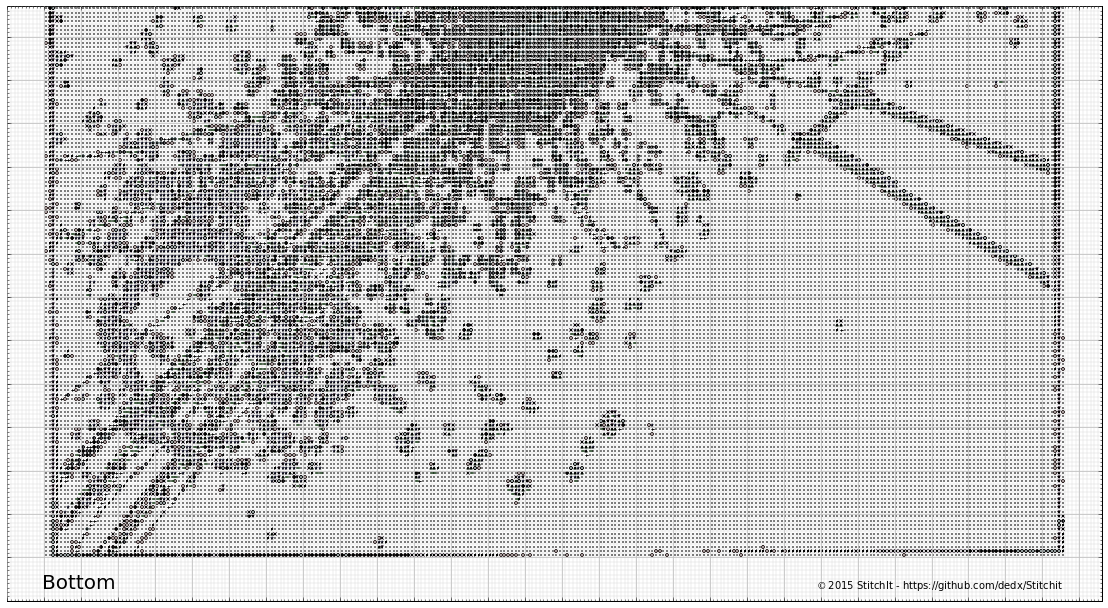

In [37]:
w,h = 16.,10.
width = min(sizex,sizey)
red = (width/w) # % reduction
height = max(sizex,sizey)/red

plt.figure(2,figsize=(w,height/2))
ax = plt.axes([0.025, 0.025, 0.95, 0.95])

#Need these sizes in pixel space
ax.set_xlim(-10,(after.shape[1])+10) #Row,Col vs. x,y
ax.set_ylim(-10,(after.shape[0]/2)) #with padding around image
ax.xaxis.set_major_locator(plt.MultipleLocator(10.))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1.0))
ax.yaxis.set_major_locator(plt.MultipleLocator(10.))
ax.yaxis.set_minor_locator(plt.MultipleLocator(1.))
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75')
ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75')
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75')
ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75')
ax.set_xticklabels([])
ax.set_yticklabels([])

#bottom half of image
mnrow,mxrow = 0,after.shape[0]/2
mncol,mxcol = 0,after.shape[1]
print "pxymin,pxymax:\t",mnrow,mxrow
print "ymin,ymax:\t",ax.get_ylim()
print "pxxmin,pxxmax:\t",mncol,mxcol
print "xmin,xmax:\t",ax.get_xlim()

count = 0
for (skeins, floss, name, oldcolor, matchedcolor) in summary:
    #print matchedcolor
    mc = mpc[count]
    if (oldcolor.all() == 0):
        x,y = locate_color(flipped[mnrow:mxrow,mncol:mxcol,...],oldcolor)
        #Use small dot for black pixels
        plt.plot(x+0.5,y+0.5, color='k',marker='.', lw = 0,markersize=2)
    else:
        x,y = locate_color(flipped[mnrow:mxrow,mncol:mxcol,...],oldcolor)
        plt.plot(x+0.5, y+0.5, marker="$%s$" % symbol[count], lw = 0,markersize=3)
        #plt.plot(x+0.5, y+0.5, color=mc,marker='o', lw = 0,markersize=3)
        count += 1

plt.text(0,-7,"Bottom",fontsize=20);
plt.text(after.shape[0]-45,-7,"$\copyright$ 2015 StitchIt - https://github.com/dedx/Stitchit")
plt.savefig("PatternBottom.pdf",papertype='ledger')

#To-Dos:

1. Choose a minimum size for the squares in the grid, then break up the pattern into 8.5x11" paper pieces with those squares.
2. Add page numbers to the pages
3. Put the pattern creation into a single function
4. Look up color-matching algorithms - brightness and depth seem to be important figures to try to match as well as the closeness in RGB vector space.
5. Figure out how to provide the floss color dictionary to the K-means algorithm for semi-supervised clustering.

##### 